In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd 

In [2]:
def add_colors_multisurvey(df):
    df["coljh"] = df.wjmag - df.whmag
    df["coljk"] = df.wjmag - df.wkmag
    df["colj1"] = df.wjmag - df.w1
    df["colj2"] = df.wjmag - df.w2
    df["colj3"] = df.wjmag - df.w3
    df["colj4"] = df.wjmag - df.w4

    df["colhk"] = df.whmag - df.wkmag
    df["colh1"] = df.whmag - df.w1
    df["colh2"] = df.whmag - df.w2
    df["colh3"] = df.whmag - df.w3
    df["colh4"] = df.whmag - df.w4

    df["colk1"] = df.wkmag - df.w1
    df["colk2"] = df.wkmag - df.w2
    df["colk3"] = df.wkmag - df.w3
    df["colk4"] = df.wkmag - df.w4

    df["col12"] = df.w1 - df.w2
    df["col13"] = df.w1 - df.w3
    df["col14"] = df.w1 - df.w4
    df["col23"] = df.w2 - df.w3
    df["col24"] = df.w2 - df.w4
    df["col34"] = df.w3 - df.w4

    return df

In [3]:
def photo_cuts(df):
    sat = {"w1":2.0, "w2":1.5, "w3":-3.0, "k":8.5}
    fnt = {"w1":16.83, "w2":15.6, "w3":11.32, "k":15.5}
    snr = 3
    
    cuts = (df.w1 > sat["w1"]) & (df.w2 > sat["w2"]) & (df.w3 > sat["w3"]) & (df.kmag > sat["k"]) & (df.w1 < fnt["w1"]) & (df.w2 < fnt["w2"]) & (df.w3 < fnt["w3"]) & (df.kmag < fnt["k"]) & (df.w1snr > snr) & (df.w2snr > snr) & (df.w3snr > snr) & (df.ccflag.map(lambda flag: flag.startswith("00")))

    return df[cuts]
def agb_cuts(df):
    cuts = (df.coljk > 1.1) & (df.col23 < 2.5) & (df.col23 > -0.1)
    
    return df[cuts]
def remove_ysos(df):
    cuts = (df.col12 < 0.2) | (df.col12 > 0.75*df.col23 - 0.33) | (df.col12 < -1. * df.col23 + 1.5)
    
    return df[cuts]
def remove_excess(df):
#     cut = (df.coljk < 2.5 * df.col23 + 1.5) & (df.col23 > 0.4) & ~((df.col12 < 0.3) & (df.col23 > 1.2))
    
    return df[cut]

In [10]:
def all_color_color(infile, figsize=(12,6), interpolation="nearest", cmap=plt.cm.gnuplot, jklim=None, w23hi=None, w23lo=None, outfile=None, binsize=1):
    obj_dir = "/Users/Nick/Documents/AGBstuff/new_work/agb_candidates/"
    df = pd.read_csv(obj_dir + infile, sep=",")
    if "col12" not in df.keys():
        df = remove_ysos(agb_cuts(photo_cuts(add_colors_multisurvey(df))))
#         df = remove_excess(remove_ysos(agb_cuts(photo_cuts(add_colors_multisurvey(df)))))
        df.glon[df.glon > 180] = df.glon[df.glon > 180] - 360
    else:
        print len(df)
        df = df[df.col23 > 0.1]
#         df = remove_excess(df[df.col23 > 0.1])
        
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.25, hspace=0.25, left=0.09, right=0.85, top=0.97, bottom=0.1)
    ax = plt.subplot2grid((2,2),(0,0),colspan=2)

    dx = binsize
    dy = binsize
    
    xbins = np.arange(-180, 180+dx, dx)
    ybins = np.arange(-90, 90+dy, dy)
    H, xedges, yedges = np.histogram2d(df.glon, df.glat, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    imap = ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation=interpolation, cmap=cmap, origin="lower")

    ax.set_xlim(-180, 180)
    ax.set_xlabel("gal $l$ (deg)")
    ax.set_ylim(-90, 90)
    ax.set_ylabel("gal $b$ (deg)")
    ax.minorticks_on()

    
    ax = plt.subplot2grid((2,2),(1,0))
    xcolor = df.col23
    ycolor = df.coljk
    dx = dy = 0.05
    
    xbins = np.arange(-4, 5.+dx, dx)
    ybins = np.arange(-4, 5.+dy, dy)

    H, xedges, yedges = np.histogram2d(xcolor, ycolor, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation=interpolation, cmap=cmap, origin="lower")

    if jklim:
        ax.plot([-1,4],[jklim,jklim],linestyle="--",color='white', linewidth=2)
    if w23hi:
        ax.plot([w23hi,w23hi],[-2,6],linestyle="--",color='k', linewidth=2)
    if w23lo:
        print w23lo
        ax.plot([w23lo,w23lo],[-2,6],linestyle="--",color='k', linewidth=2)

#     ax.set_xticks(np.arange(0, 4.+1., 1.))
    ax.set_xlim(0, 2.5)
    ax.set_xlabel("W2 - W3")
    ax.set_yticks(np.arange(0, 4.+1., 1.))
    ax.set_ylim(0.5, 4.4)
    ax.set_ylabel("J - K$_s$")
    ax.minorticks_on()

    ax = plt.subplot2grid((2,2),(1,1))
    xcolor = df.col23
    ycolor = df.col12
    dx = 0.05
    dy = 0.05
    
    xbins = np.arange(-0.5, 3.9+dx, dx)
    ybins = np.arange(-0.5, 3.9+dy, dy)
    
    H, xedges, yedges = np.histogram2d(xcolor, ycolor, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation=interpolation, cmap=cmap, origin="lower")
    if w23hi:
        ax.plot([w23hi,w23hi],[-2,6],linestyle="--",color='k', linewidth=2)
    if w23lo:
        ax.plot([w23lo,w23lo],[-2,6],linestyle="--",color='k', linewidth=2)

    ax.set_xlim(0, 2.5)
    ax.set_xlabel("W2-W3")
    ax.set_ylim(-0.5, 1.9)
    ax.set_ylabel("W1-W2")
    ax.minorticks_on()

#     cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
#     cbar = plt.colorbar(imap, cax = cax, ticks=np.arange(vmin, 1.0+0.1, 0.1))
    
    if outfile:
        plt.savefig(outfile)

    plt.show()

300745


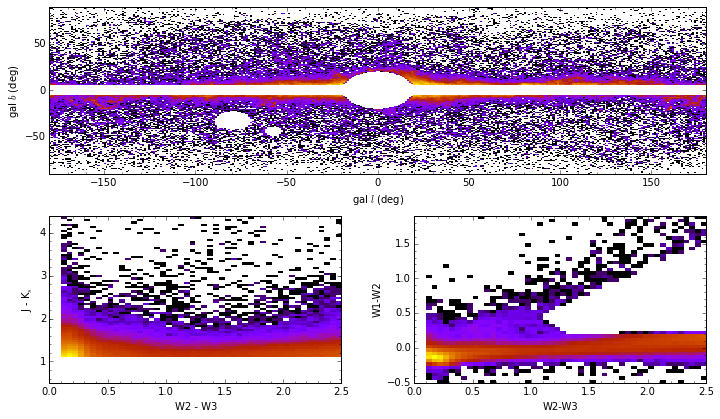

1622189


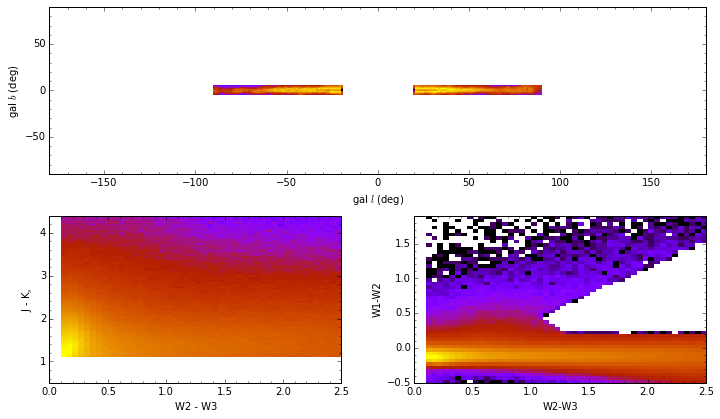

236638


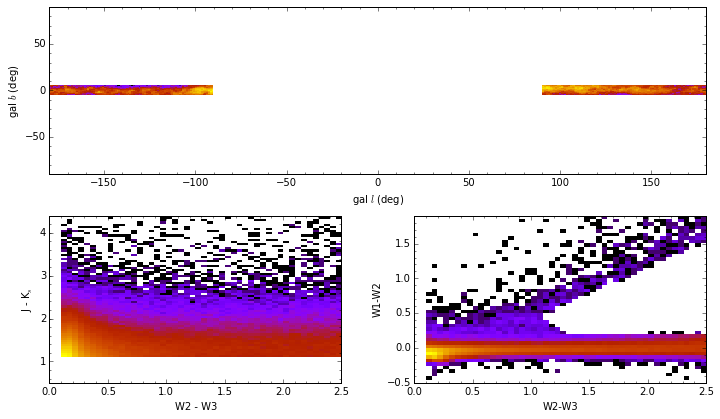

693598


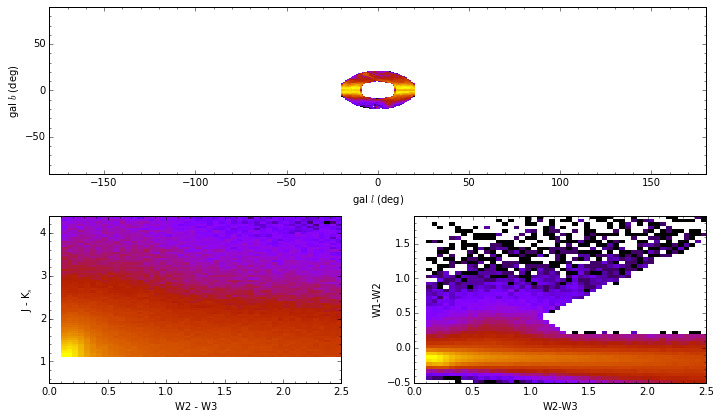

648273


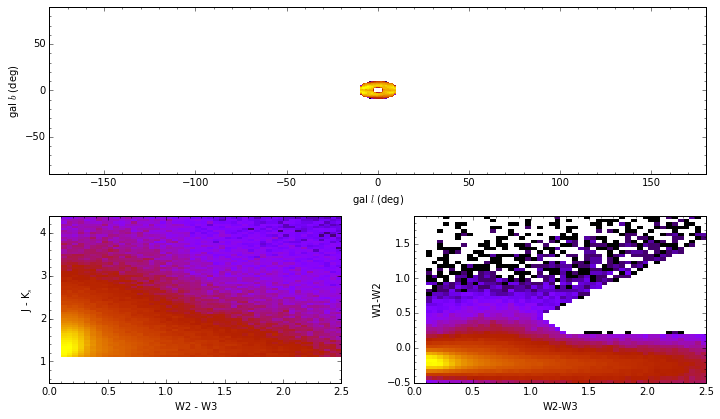

46414


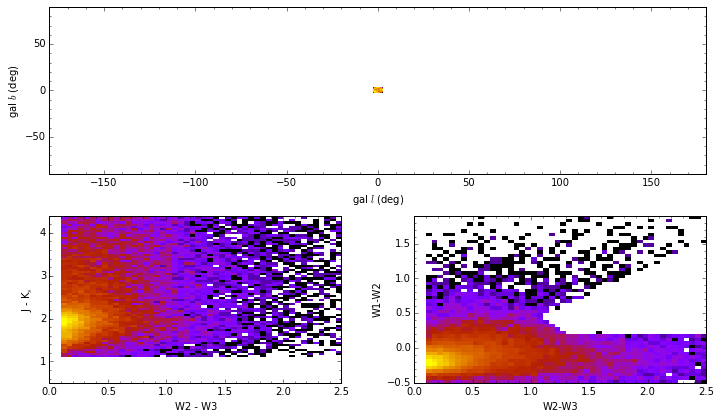

In [11]:
all_color_color("candidates_region_0.dat")
all_color_color("candidates_region_1.dat")
all_color_color("candidates_region_2.dat")
all_color_color("candidates_region_3.dat")
all_color_color("candidates_region_4.dat")
all_color_color("candidates_region_5.dat")


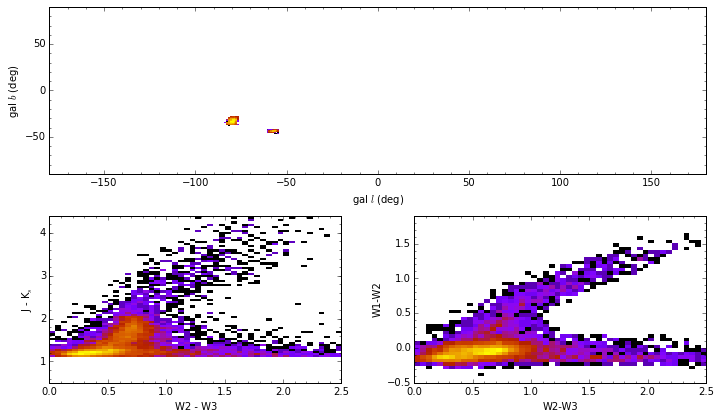

In [12]:
all_color_color("../samples/ogle_2mass_allwise_alldata.dat")